In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as q

In [29]:
a = q.basis(4, 0)
abar = q.basis(4, 1)
b = q.basis(4, 2)
bbar = q.basis(4, 3)

def sigmax(state1, state2):
    return state1 * state2.dag() + state2 * state1.dag()

def sigmay(state1, state2):
    return -1j * (state1 * state2.dag() - state2 * state1.dag())

def sigmaz(state1, state2):
    return state1 * state1.dag() - state2 * state2.dag()

def sigmam(state1, state2):
    return (sigmax(state1, state2) - 1j * sigmay(state1, state2)) / 2

def sigmap(state1, state2):
    return (sigmax(state1, state2) + 1j * sigmay(state1, state2)) / 2

In [58]:
class Pulse:
    def __init__(self, Omega):
        self._Omega = Omega

    def Omega_x(self, t, args=None):
        if isinstance(args, dict) and "t_start" in args:
            t_start = args["t_start"]  # TODO: solve t_start
        return np.real(self._Omega(t, args))

    def Omega_y(self, t, args=None):
        if isinstance(args, dict) and "t_start" in args:
            t_start = args["t_start"]  # TODO: solve t_start
        return np.imag(self._Omega(t, args))


class FourLevel:
    def __init__(self):
        self.states = {
            "a": q.basis(4, 0),
            "abar": q.basis(4, 1),
            "b": q.basis(4, 2),
            "bbar": q.basis(4, 3),
        }
        self.rhos = [fl.states[state_2] * fl.states[state_1].dag() for state_1 in fl.states for state_2 in fl.states]
        self._energies = q.Qobj(np.zeros((4,4)))
        self._segments = []
        self.t_total = 0

    def sigmax(self, state1, state2):
        return state1 * state2.dag() + state2 * state1.dag()
    
    def sigmay(self, state1, state2):
        return -1j * (state1 * state2.dag() - state2 * state1.dag())
    
    def sigmaz(self, state1, state2):
        return state1 * state1.dag() - state2 * state2.dag()
    
    def sigmam(self, state1, state2):
        return (sigmax(state1, state2) - 1j * sigmay(state1, state2)) / 2
    
    def sigmap(self, state1, state2):
        return (sigmax(state1, state2) + 1j * sigmay(state1, state2)) / 2

    def add_segment(self, duration, pulses=None):
        t_start = self.t_total
        self.t_total += duration
        t_end = self.t_total
        self._segments.append((t_start, t_end, pulses))

    def set_energies(self, energies):
        self._energies = q.Qobj(np.diag(energies))

    def energy_function(self, t, args=None):
        return 1

    def _hamiltonian(self, pulses):
        H = [[self._energies, self.energy_function]]
        if pulses is not None:
            for s1_name, s2_name in pulses:
                pulse = pulses[(s1_name, s2_name)]
                s1 = self.states[s1_name]
                s2 = self.states[s2_name]
                H.append([self.sigmax(s1, s2) / 2, pulse.Omega_x])
                H.append([self.sigmay(s1, s2) / 2, pulse.Omega_y])
        return H
    
    def simulate(self, tlist):
        tlist = np.array(tlist)
        init_state = self.states["a"]
        for t_start, t_end, pulses in self._segments:
            mask = np.bitwise_and(tlist >= t_start, tlist <= t_end)
            return q.mesolve(self._hamiltonian(pulses), init_state, tlist[mask], [], self.rhos)

In [158]:
class ThreeLevelCQB(FourLevel):
    def __init__(self, pi_time, delay_time, Omega, delta):
        super().__init__()
        self._pi_time = pi_time
        self._delay_time = delay_time
        self._Omega = Omega
        self._delta = delta
        self._rf_center = 119e6 * 2 * np.pi
        self._Zeeman_shift = 150e3 * 2 * np.pi
        self.set_energies([0, 0, self._rf_center - self._Zeeman_shift, self._rf_center + self._Zeeman_shift])
        self.add_segment(self._pi_time * 2 + self._delay_time, {("a", "b"): Pulse(self.Omega_ab), ("a", "bbar"): Pulse(self.Omega_abbar)})

    def Omega_ab(self, t, args):
        if t < self._pi_time:
            return self._Omega * np.sin((self._rf_center - self._Zeeman_shift) * t)
        elif t < self._pi_time + self._delay_time:
            return 0
        else:
            return self._Omega * np.sin((self._rf_center - self._Zeeman_shift) * t)

    def Omega_abbar(self, t, args):
        if t < self._pi_time:
            return self._Omega * np.sin((self._rf_center + self._Zeeman_shift + self._delta) * t)
        elif t < self._pi_time + self._delay_time:
            return 0
        else:
            return self._Omega * np.sin((self._rf_center + self._Zeeman_shift + self._delta) * t)
    
    def simulate(self):
        tlist = np.linspace(0, self._pi_time * 2 + self._delay_time, 1000)
        init_state = self.states["a"]
        
        return (tlist, q.mesolve(self._hamiltonian(self._segments[0][2]), init_state, tlist, [], self.rhos, options=q.Options(nsteps=500000)))

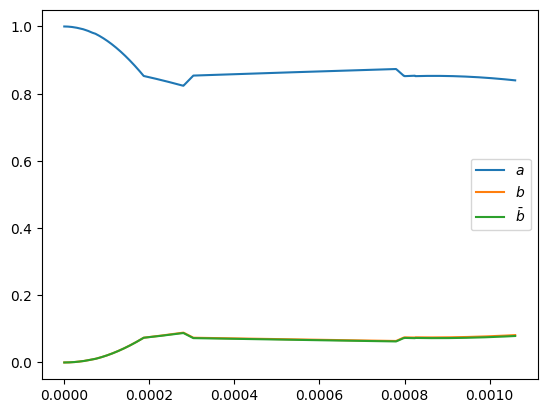

In [159]:
cqb = ThreeLevelCQB(pi_time=0.28e-3, delay_time=0.5e-3, Omega=2*np.pi*1e3, delta=2*np.pi*0)
tlist, output = cqb.simulate()

fig, ax = plt.subplots()
ax.plot(tlist, output.expect[0], label="$a$")
#ax.plot(tlist, output.expect[4], label="$\\bar{a}$")
ax.plot(tlist, output.expect[10], label="$b$")
ax.plot(tlist, output.expect[15], label="$\\bar{b}$")
ax.legend()
plt.show()

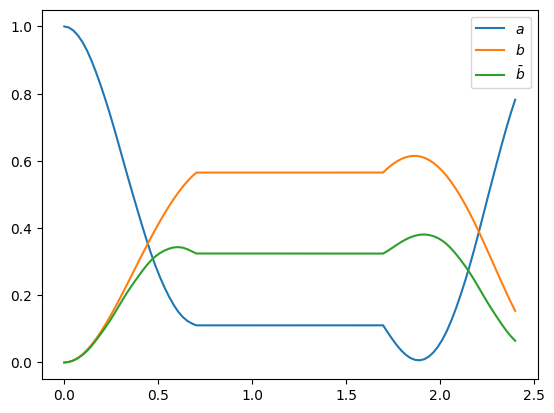

In [152]:
pi_time = 0.7
delay_time = 1

def Omega_ab(t, args):
    a = np.sin(2 * np.pi * 20 * t)
    if t < pi_time:
        return 2 * np.pi * a
    elif t < pi_time + delay_time:
        return 0
    else:
        return 1 * 2 * np.pi * a
        
def Omega_abar(t, args):
    a = np.sin(2 * np.pi * 99.5 * t)
    if t < pi_time:
        return 2 * np.pi * a
    elif t < pi_time + delay_time:
        return 0
    else:
        return 1 * 2 * np.pi * a

fl = FourLevel()
energies = np.array([0, 1, 20.0, 100.0]) * 2 * np.pi
fl.set_energies(energies)
fl.add_segment(pi_time * 2 + delay_time, {("a", "b"): Pulse(Omega_ab), ("a", "bbar"): Pulse(Omega_abar)})
tlist = np.linspace(0, pi_time * 2 + delay_time, 100)
output = fl.simulate(tlist)

fig, ax = plt.subplots()
ax.plot(tlist, output.expect[0], label="$a$")
#ax.plot(tlist, output.expect[4], label="$\\bar{a}$")
ax.plot(tlist, output.expect[10], label="$b$")
ax.plot(tlist, output.expect[15], label="$\\bar{b}$")
ax.legend()
plt.show()